<a href="https://colab.research.google.com/github/klemenHamiti/LTFS-Loan-Default-Prediction/blob/master/Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from collections import Counter
%matplotlib inline

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
# Pipeline and data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelBinarizer, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, StratifiedKFold

# Models
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

# Model evaluation
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [0]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    '''
    Transforms pandas.DataFrame object with selected columns to numpy array
    '''
    def __init__(self, col_names):
        '''
        Args:
            col_names (list): list of columns in DataFrame to keep
        '''
        self.col_names = col_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        '''
        Returns:
            numpy.ndarray
        '''
        return X[self.col_names].values

In [0]:
class DatesToNums(BaseEstimator, TransformerMixin):
    '''
    Transforms time in str format to numeric values for months
    '''
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        '''
        Returns:
            numpy.ndarray
        '''
        new_vals = []
        for i in range(X.shape[1]):
            new_vals.append(list(map(self.join_loan_len, X[:,i].ravel())))
        return np.array(new_vals).T
    
    def join_loan_len(self, val):
        y, m = val.split(' ')
        y = y.split('y')[0]
        m = m.split('m')[0]
        return int(y)*12 + int(m)

In [0]:
class ExtractTotalAllowance(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return (X[:,0] / (X[:,1] / 100)).reshape(-1,1)

In [0]:
class ExtractOwnMoney(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return (X[:,0] - X[:,1]).reshape(-1,1)

In [0]:
class CustomEncoder(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        new_vals = list(map(self.f, X.ravel()))
        return np.array(new_vals).reshape(-1,1)
        
    def f(self, val):
        if val == 'Salaried':
            val = 1
        elif val == 'Self employed':
            val = 0

In [0]:
class ReduceWithPCA(BaseEstimator, TransformerMixin):
    '''
    Reduces the dimensionality of the data with PCA
    '''
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        pca = PCA(n_components=1)
        return pca.fit_transform(X)

In [0]:
class MyLabelBinarizer(TransformerMixin):
    
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
        
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    
    def transform(self, x, y=0):
        return self.encoder.transform(x)

In [0]:
def computeChi2(X_cat, y, cat_cols):
    scores = {}
    for i,col in enumerate(cat_cols):
        table = [[np.sum((X_cat[:,i]==1)&(y==1)), np.sum((X_cat[:,i]==1)&(y==0))],
                 [np.sum((X_cat[:,i]==0)&(y==1)), np.sum((X_cat[:,i]==0)&(y==0))]]
        if np.count_nonzero(table) == 4:
            p = chi2_contingency(table)[1]
            if p > 0.05:
                scores[col] = ('Independent Variables', p)
            else:
                scores[col] = ('Dependent Variables', p)
        else:
            scores[col] = 'Zero elements in table'
    return scores

In [0]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1,], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [0]:
df_train = pd.read_csv('train_aox2Jxw/train.csv')
df_test = pd.read_csv('test_bqCt9Pv.csv')

# keep unique ID for predictions
df_test.index = df_test['UniqueID']

In [0]:
X = df_train.drop('loan_default', axis=1).copy()
y = df_train['loan_default'].values.copy()

X_test = df_test.copy()

In [0]:
# # test dependence of employment to loan default
# binarizer = LabelBinarizer()
# X['empl'] = SimpleImputer(strategy='most_frequent').fit_transform(X['Employment.Type'].values.reshape(-1,1))
# X['empl'] = binarizer.fit_transform(X['empl'])

# X_cat = X[['MobileNo_Avl_Flag',
#            'Aadhar_flag',
#            'PAN_flag',
#            'Driving_flag',
#            'Passport_flag',
#            'empl']]

# computeChi2(X_cat.values, y, X_cat.columns)

In [0]:
# Unique ids are not significant
id_cols = [col for col in df_train.columns if ('ID' in col) | ('id' in col)]

# Unsignificant categorical values based on chi2 test and domain knowledge
unsignificant = ['PERFORM_CNS.SCORE.DESCRIPTION',
                 'PAN_flag',
                 'MobileNo_Avl_Flag',
                 'Date.of.Birth',
                 'DisbursalDate']

unsignificant = unsignificant + id_cols

# Drop the values
X = df_train.drop(unsignificant+['loan_default'], axis=1) # empl used only for testing purposes
X_test = df_test.drop(unsignificant, axis=1)

# Columns to keep
columns = X.columns.to_list()
# New shape of X
print(X.shape)

(233154, 27)


In [0]:
cat_atribs = ['Employment.Type',
              'CREDIT.HISTORY.LENGTH',
              'AVERAGE.ACCT.AGE',
              'Aadhar_flag',
              'Driving_flag',
              'Passport_flag']

pca_atribs = ['PRI.CURRENT.BALANCE','PRI.SANCTIONED.AMOUNT','PRI.DISBURSED.AMOUNT',
              'SEC.CURRENT.BALANCE','SEC.SANCTIONED.AMOUNT','SEC.DISBURSED.AMOUNT']

extractions = ['asset_cost', 'disbursment_amount', 'asset_cost', 'ltv']

num_atribs = [col for col in columns if col not in cat_atribs+pca_atribs]

In [0]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_atribs)),
    ('min_max_scaler', MinMaxScaler()),
])

loan_pipeline = Pipeline([
    ('selector', DataFrameSelector(['asset_cost', 'ltv'])),
    ('extract_allowance', ExtractTotalAllowance()),
    ('scaler', MinMaxScaler()),
])

own_money_pipeline = Pipeline([
    ('selector', DataFrameSelector(['disbursed_amount', 'asset_cost'])),
    ('extract_loan', ExtractOwnMoney()),
    ('min_max_scaler', MinMaxScaler()),
])

# Contains nan values
empl_pipeline = Pipeline([
    ('selecor', DataFrameSelector(['Employment.Type'])),
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('ecoder', MyLabelBinarizer()),
    ('encoder', CustomEncoder()),
])

dates_pipeline = Pipeline([
    ('selector', DataFrameSelector(['CREDIT.HISTORY.LENGTH', 'AVERAGE.ACCT.AGE'])),
    ('credit_history', DatesToNums()),
])

pri_acc_pipeline = Pipeline([
    ('selector', DataFrameSelector(['PRI.CURRENT.BALANCE','PRI.SANCTIONED.AMOUNT','PRI.DISBURSED.AMOUNT'])),
    ('std_scaler', StandardScaler()),
    ('pca', ReduceWithPCA()),
    ('min_max_scaler', MinMaxScaler()),
])

sec_acc_pipeline = Pipeline([
    ('selector', DataFrameSelector(['SEC.CURRENT.BALANCE','SEC.SANCTIONED.AMOUNT','SEC.DISBURSED.AMOUNT'])),
    ('std_scaler', StandardScaler()),
    ('pca', ReduceWithPCA()),
    ('min_max_scaler', MinMaxScaler()),
])

all_else_pipeline = Pipeline([
    ('selector', DataFrameSelector(['Aadhar_flag','Driving_flag','Passport_flag'])),
])

pipeline = FeatureUnion([
    ('num_pipeline', num_pipeline),
    ('empl_pipeline', empl_pipeline),
    ('dates_pipeline', dates_pipeline),
    ('loan_pipeline', loan_pipeline),
    ('own_money_pipeline', own_money_pipeline),
    ('pca1', pri_acc_pipeline),
    ('pca2', sec_acc_pipeline),
    ('all_else', all_else_pipeline)
])

X_train = pipeline.fit_transform(X)
X_test = pipeline.transform(X_test)

In [0]:
X_train.shape

(233154, 25)

In [0]:
# Class weight balancing
cw = (len(y) - sum(y)) / sum(y)

model_params = {'learning_rate': 0.01,
                'objective':'binary:logistic',
                'eval_metric':'auc',
                'n_estimators':500,
                'max_depth':5,
                'min_child_weight':1,
                'colsample_bytetree':0.8,
                'subsample':0.8,
                'scale_pos_weight':cw,
                'seed':42,
                'gamma':0}

xgb_model = xgb.XGBRegressor(**model_params)

In [0]:
score = cross_val_score(xgb_model, X_train, y, scoring='roc_auc', cv=5)

In [0]:
score

array([0.62968881, 0.63952179, 0.64001435, 0.63520637, 0.6281739 ])

In [0]:
score.mean()

0.6345210443302411

In [0]:
score.mean()

0.6346975110944589

Area under ROC: 0.6758562905084077


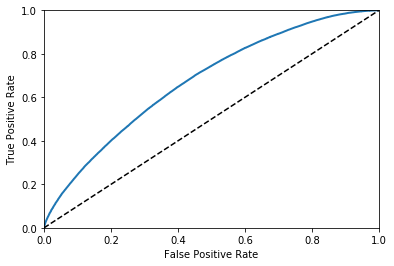

In [0]:
xgb_model.fit(X_train, y)

# Performance on train set
preds_train = xgb_model.predict(X_train)
# Area under ROC Curve
print('Area under ROC: {}'.format(roc_auc_score(y, preds_train)))
# Plot ROC Curve
fpr, tpr, treshold = roc_curve(y, preds_train)
plot_roc_curve(fpr, tpr)
plt.show()

In [0]:
# Predict the test set
preds_test = xgb_model.predict(X_test)
results = pd.DataFrame({'UniqueID':df_test.index, 'loan_default':preds_test})
results.to_csv('results2.csv', index=False)

In [0]:
#=================================================================================================================
#=================================================================================================================
#=================================================================================================================
#=================================================================================================================
#=================================================================================================================
#=================================================================================================================
#=================================================================================================================
#=================================================================================================================

In [0]:
def regress(*args):
    scores = {}
    for i in range(X_train.shape[1]):
        print(i)
        if i != 15:
            log_model = LogisticRegression(class_weight='balanced')
            log_model.fit(X_train[:,i].reshape(-1,1), y)
            score = log_model.predict(X_train[:,i].reshape(-1,1))
            scores[i] = roc_auc_score(y, score)
    return scores
score = regress(X_train, y)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [0]:
print((score))

{0: 0.5469914728836991, 1: 0.5207246986913403, 2: 0.5222623606407099, 3: 0.5165146943816712, 4: 0.5189206734200448, 5: 0.5020330962679871, 6: 0.5013193811802091, 7: 0.5002551947396328, 8: 0.507241636919701, 9: 0.5008339558631195, 10: 0.5162132507920401, 11: 0.5123583037698156, 12: 0.5161880956394544, 13: 0.5168094885392502, 14: 0.5168436400491138, 15: 0.5166291653416027, 16: 0.5239389147777036, 17: 0.5383659749277144, 18: 0.5218743033602478, 19: 0.501137098233701, 20: 0.5, 21: 0.5184788527451204, 22: 0.5006560256470421, 23: 0.5010638334140978, 24: 0.5004248256674256}


In [0]:
print((score))

{0: 0.5469914728836991, 1: 0.5092309622880735, 2: 0.5482033273832243, 3: 0.5207246986913403, 4: 0.5222623606407099, 5: 0.5165146943816712, 6: 0.5189206734200448, 7: 0.5020330962679871, 8: 0.5013193811802091, 9: 0.5002551947396328, 10: 0.507241636919701, 11: 0.5008339558631195, 12: 0.5162132507920401, 13: 0.5123583037698156, 14: 0.5161880956394544, 16: 0.5168436400491138, 17: 0.5166291653416027, 18: 0.5239389147777036, 19: 0.5383659749277144, 20: 0.5218743033602478, 21: 0.501137098233701, 22: 0.5184788527451204, 23: 0.5010638334140978, 24: 0.5004248256674256}


In [0]:
log_model = LogisticRegression(class_weight='balanced')
log_model.fit(X['PRI.ACTIVE.ACCTS'])

1

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

In [0]:
def roc(y_true, y_preds):
    return roc_auc_score(y_true, y_preds)

In [0]:
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [0]:
model = Sequential()
model.add(Dense(128, input_shape=(25,), activation=tf.nn.relu))
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dense(256, activation=tf.nn.relu))
model.add(Dense(256, activation=tf.nn.relu))
model.add(Dense(256, activation=tf.nn.relu))
model.add(Dense(1, activation=tf.nn.relu))

cw = len(y_train) / (2 * np.bincount(y_train))

optim = optimizers.RMSprop(lr = 0.0001, decay=1e-3)

model.compile(optimizer=optim,
              loss='binary_crossentropy',
              metrics=[roc])

In [0]:
for train_index, test_index in skfold.split(X, y):
    model.fit(X[train_index], y[train_index], class_weight=cw)
    preds = model.predict(X[test_index])
    print(roc_auc_score(y[test_index], preds))